In [13]:
import cftime
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate

%matplotlib widget

In [6]:
# Load mission 19 data and plot tracks over the radar image
mission_nc_path = '../data/mission_19.nc'
mission_dataset = nc.Dataset(mission_nc_path, mode='r')

# Plot the microSWIFT tracks over the radar image
x_locations = np.ma.masked_invalid(mission_dataset['xFRF'])
y_locations = np.ma.masked_invalid(mission_dataset['yFRF'])
vertical_accel = np.ma.masked_invalid(mission_dataset['acceleration_z_body'])
velocity_ew = np.ma.masked_invalid(mission_dataset['velocity_ew'])
time_vals = mission_dataset['time'][:]

/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_69471/608455626.py:16: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  bathy_f = interpolate.interp2d(xFRF_grid, yFRF_grid, bathy)
/opt/homebrew/Caskroom/mambaforge/base/envs/surfing-transport/lib/python3.12/site-packages/scipy/interpolate/_interpolate.py:286: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=74,56 m=3876 fp=0.004118 s=0.

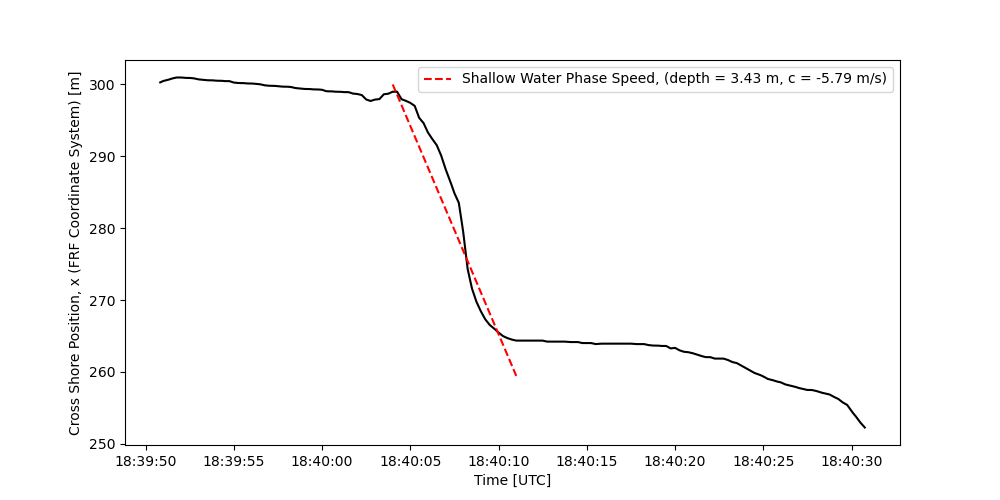

In [14]:
# Plot the time series of cross shore and along shore location with the breaking events
trajectory_num = 5

time = cftime.num2pydate(mission_dataset['time'],
                            units=mission_dataset['time'].units,
                            calendar=mission_dataset['time'].calendar)

# Set time index 
time_ind = 15730

# breaking event depth
bathy_file = '../data/FRF_geomorphology_DEMs_surveyDEM_20211021.nc'
bathy_dataset = nc.Dataset(bathy_file)
bathy = bathy_dataset['elevation'][0,:,:]
xFRF_grid, yFRF_grid = np.meshgrid(bathy_dataset['xFRF'][:],bathy_dataset['yFRF'][:])
bathy_f = interpolate.interp2d(xFRF_grid, yFRF_grid, bathy)
breaking_depth = bathy_f(x_locations[trajectory_num, time_ind+205],
                         y_locations[trajectory_num, time_ind+205]).item()

# phase speed for breaking 
c =  -1 * np.sqrt(9.8 * np.abs(breaking_depth)) 
seconds_phase_speed = np.linspace(0, 7, 15)
distance_traveled_at_phase_speed = (c * seconds_phase_speed) # offset for fitting to the plot
t = pd.date_range(start='2021-10-08T18:40:04',
                  end='2021-10-08T18:40:11',
                  periods=15)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(time[time_ind:time_ind+480], x_locations[trajectory_num,time_ind:time_ind+480], color='k')
ax.plot(t.values, distance_traveled_at_phase_speed+300, color='r', linestyle='dashed', 
         label=f'Shallow Water Phase Speed, (depth = {np.round(np.abs(breaking_depth), 2)} m, c = {np.round(c, 2)} m/s)')
ax.set_xlabel('Time [UTC]')
ax.set_ylabel('Cross Shore Position, x (FRF Coordinate System) [m]')
ax.legend()
fig.savefig('../figures/jump_example.png')